# Exercise 4 - Neural Networks Learning

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fmin_cg
import scipy.io as si
from scipy.io import loadmat
from scipy.optimize import minimize
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Load Data

In [2]:
data = loadmat('ex4data1.mat')
print(data.keys())
X = data['X']
y = data['y']

yy = data['y'].flatten()

# replace 10 -> 0 
# re-cast y
y = np.zeros((len(yy), 10))
for ii in range(y.shape[0]):
    y[ii, yy[ii]-1] = 1

print('\nX:',X.shape, '(without intercept)')
print('y:',y.shape)

m,n = X.shape
print('\nNumber of features (n): %.0f'%(n))
print('Number of training examples (nm): %.0f'%(m))

weights = loadmat('ex4weights.mat')
weights.keys()

theta1, theta2 = weights['Theta1'], weights['Theta2']
print('\ntheta1 :', theta1.shape)
print('theta2 :', theta2.shape)

nn_params = np.concatenate((np.reshape(theta1, theta1.size, order = 'F'),
                            np.reshape(theta2, theta2.size, order = 'F')))
print('params :', nn_params.shape)



dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

X: (5000, 400) (without intercept)
y: (5000, 10)

Number of features (n): 400
Number of training examples (nm): 5000

theta1 : (25, 401)
theta2 : (10, 26)
params : (10285,)


### Display Sammples

There are 5000 training examples in ex4data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.
$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\ - \left(x^{(2)} \right)^T - \\ \vdots \\ - \left(x^{(m)} \right)^T - \\ \end{bmatrix} $$


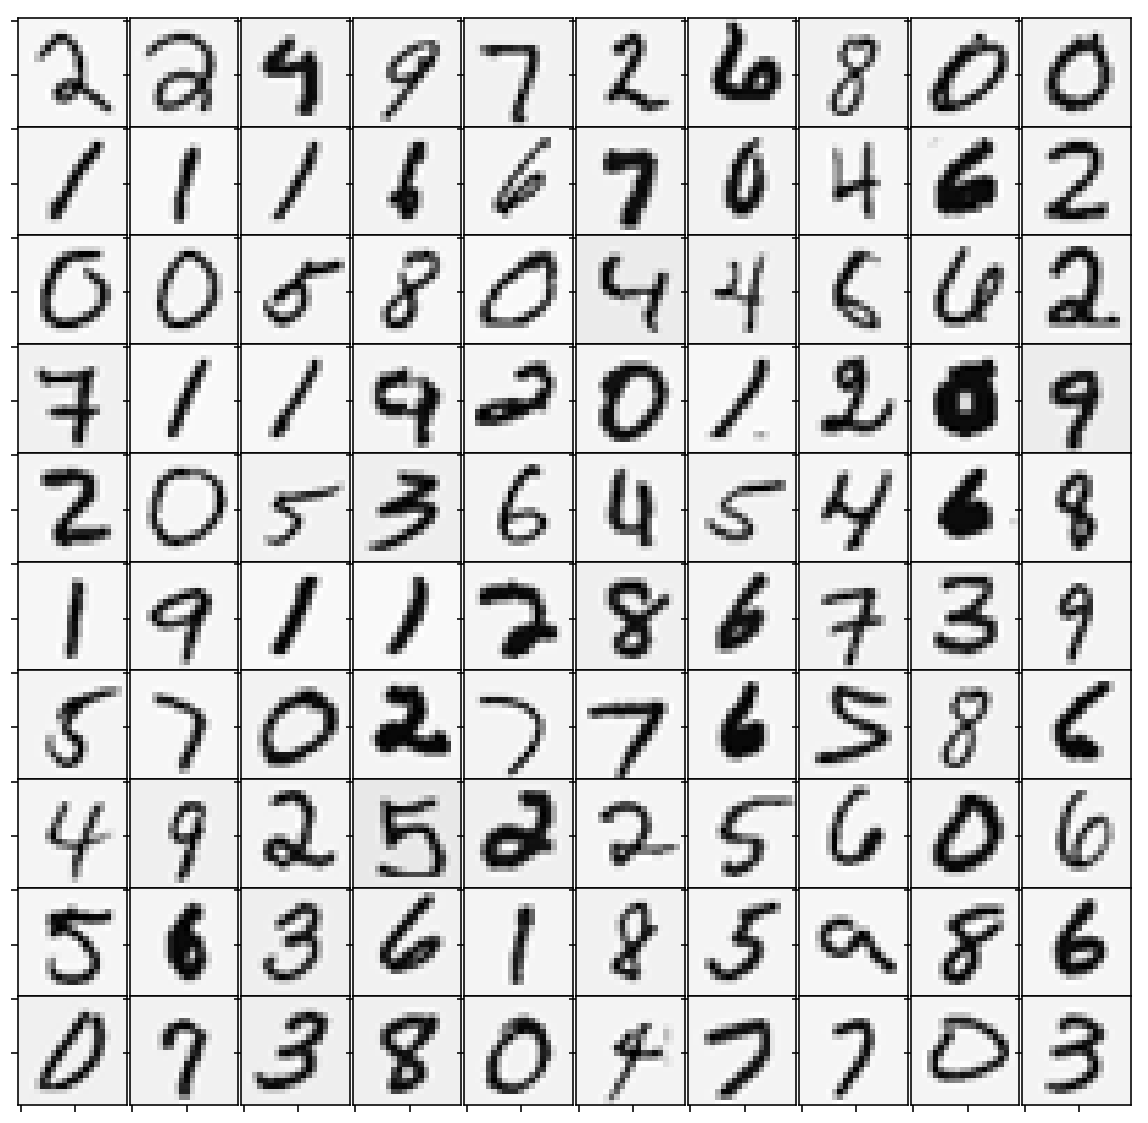

In [3]:
def displayData(X, nrows = 10, ncols = 10):
    
    # set up array
    fig, axarr = plt.subplots(nrows = nrows, ncols = ncols,
                              figsize = (nrows, ncols))
    
    # loop over randomly drawn numbers
    for ii in range(nrows):
        for jj in range(ncols):
            ind = np.random.randint(X.shape[0])
            tmp = X[ind,:].reshape(20, 20, order = 'F')
            axarr[ii,jj].imshow(tmp, cmap = 'gray_r')
            plt.setp(axarr[ii,jj].get_xticklabels(), visible = False)
            plt.setp(axarr[ii,jj].get_yticklabels(), visible = False)
    
    fig.subplots_adjust(hspace = 0, wspace = 0)
    
displayData(X)

### Neural Networks - Feed Forward and Cost Function

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables X and y above.


![caption](NN.png)


It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables X and y above.

Input layer size = 400 (20 x 20 pixels) <br>
Hidden layer size = 25<br>
Number of labels or output layers = 10<br>

the values of each of the activation nodes ias as follows <br>
$$a_1^{(2)} = g(\Theta_{10}^{(1)}x_0 + \Theta_{11}^{(1)}x_1 + \Theta_{12}^{(1)}x_2 + \Theta_{13}^{(1)}x_3) \Rightarrow a_1^{(2)} = g(z_1^{(2)})$$<br>
$$a_2^{(2)} = g(\Theta_{20}^{(1)}x_0 + \Theta_{21}^{(1)}x_1 + \Theta_{22}^{(1)}x_2 + \Theta_{23}^{(1)}x_3) \Rightarrow a_2^{(2)} = g(z_2^{(2)})$$<br>
$$a_3^{(2)} = g(\Theta_{30}^{(1)}x_0 + \Theta_{31}^{(1)}x_1 + \Theta_{32}^{(1)}x_2 + \Theta_{33}^{(1)}x_3) \Rightarrow a_3^{(2)} = g(z_3^{(2)})$$<br>
$$h_{\Theta}(x) = g(\Theta_{10}^{(2)}a_0 + \Theta_{11}^{(2)}a_1 + \Theta_{12}^{(1)}a_2. +\Theta_{13}^{(1)}a_3) = g(z^{(3)}) $$<br>

in vectorisation mode for settings $x = a^{(i)}$ we can write 
$$z^{(j)} = \Theta^{(j-1)}a^{(j-1)}$$

Vectorised implemetations of Forward Propogation:
$$a^{(1)} = x$$
$$z^{(2)} = \Theta^{(1)} a^{(1)}$$
$$a^{2} = g(z^{(2)})$$ 
$$add... a_0^{(2)} = 1)$$
$$z^{(3)} = \Theta^{(2)}a^{(2)}$$
$$h_{\Theta}(x) = a^{(3)}  = g(z^{(3)})$$


Sigmoid gradient
$$g′(z)=g(z)(1−g(z))$$

where
$$g(z)=\frac{1}{1+e^{-z}}$$


Cost Function without regularisation
$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[y^{(i)}_{k} log(( h_\theta(x^{(i)}))_k)-(1-y^{(i)}_k)log(1-h_\theta(x^{(i)}))_k)\big]$$

Vectorised Cost Junction
$$ $$

### Sigmoid and Sigmoid Gradient Functions

At 0 sigmoid gradient is 0.25


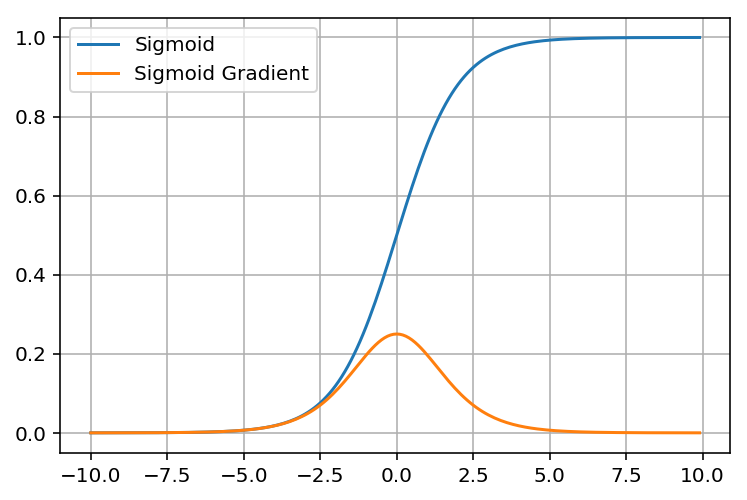

In [18]:

def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return(g)

def sigmoidGradient(z):
    dg = sigmoid(z) * (1 - sigmoid(z))
    return(dg)


Xaxis = np.arange(-10,10, 0.1)

print('At 0 sigmoid gradient is', sigmoidGradient(0))


plt.plot(Xaxis, sigmoid(Xaxis), label = 'Sigmoid')
plt.plot(Xaxis, sigmoidGradient(Xaxis), label = 'Sigmoid Gradient')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
L = 400 # Input layer size = 400 (20x20 pixels)
input_layer_size = 400 
hidden_layer_size = 25
num_labels = 10 
#n_training_samples = X.shape[0]
""""
X = input layer
y = classes

nn_params : 1D vector with parameters for neural net
input_layer_size: 400
hidden_layer_size: 25
num_labels: number of labels or size of final layer
X: input data
y: classes
reg: regularization coefficient


"""
#Neural Network Cost Function
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params (array). The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size (int). Number of features for the input layer. 
    
    hidden_layer_size (int). Number of hidden units in the second layer.
    
    num_labels (int). Total number of labels, or equivalently number of units in output layer. 
    
    X : (array).Input dataset. A matrix of shape (m x input_layer_size).
    
    y : (array). Dataset labels. A vector of shape (m,).
    
    reg : (float)Regularization parameter.
 
    Returns
    -------
    J (float) The computed value for the cost function at the current weight values.
    
    grad (array) An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    """
    
    """
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    """

    # tolerance for sigmoid function.
    # i.e., 1-htheta cannot be less than 1e-15
    # this fixes loss of precision errors
    eps = 1e-15
    
    # sizes
    m, n = X.shape
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size +1)],
                        (hidden_layer_size, input_layer_size + 1), order = 'F')
    
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                        (num_labels, (hidden_layer_size + 1)), order = 'F')
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
    
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)
    
    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    htheta = sigmoid(z3)
    
    # cost function
    J = - 1 / m * np.sum((np.sum(np.log(htheta) * y) + np.sum(np.log(1 - htheta + eps) * (1 - y))\
                          - reg / 2 * (np.sum(Theta1[:, 1:]**2) + np.sum(Theta2[:, 1:] ** 2)))) 
    
    """
    Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. 
    """
        
    # back prop
    delta3 = htheta - y
    delta2 = np.dot(delta3, Theta2)[:,1:] * sigmoidGradient(z2)
    #print np.dot(htheta, Theta2)[:,1:].shape, sigmoidGradient(z2).shape
        
    Delta1 = np.dot(delta2.T, X)
    Delta2 = np.dot(delta3.T, a2)
    
    Theta1_grad = 1 / m * Delta1
    Theta2_grad = 1 / m * Delta2
    
    # regularization
    Theta1_grad[:,1:] += reg / m * Theta1[:,1:]
    Theta2_grad[:,1:] += reg / m * Theta2[:,1:]
                
    # pack gradient
    grad = np.concatenate((np.reshape(Theta1_grad, Theta1_grad.size, order='F'),
                            np.reshape(Theta2_grad, Theta2_grad.size, order='F')))
    

    return(J, grad)

J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, reg - 0)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)


Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


### Gradient Checking

 To perform gradient checking on your parameters, unroll the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\Theta)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is outputting correct derivative values.
$$ \text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix} \quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix} $$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i−)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:
$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$, you’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).


### Random Initialisation

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.
One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$. 

In [ ]:
def randInitializeWeights(L_in, L_out):
   ''' 
    Used to initialize the parameters for a NN with random values within the range epsilon_init, -epsilon_init and of the given size

    Params:
    
    L_in : size of incoming layer
    L_out: size of outgoing layer
    
    eps_rand: a matrix with random values of the shape(L_out, L_in)
    ''''
    epsilon_int = 0.12
    eps_rand = np.random.rand(L_out, 1 +  L_in) * 2 * epsilon_int - epsilon_int
    
    return(eps_rand)

In [66]:
def computeNumericalGradient(J, theta):
    
    numgrad = np.zeros(len(theta))
    perturb = np.zeros(len(theta))
    e = 1e-4
    for p in range(len(theta)):
        
        # Set perturbarion vactor
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        
        # compute numerical gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
        
    return numgrad

def checkNNGradients(reg = 0):
    
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # generate some random test data
    Theta1 = randInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = randInitializeWeights(num_labels, hidden_layer_size)
    
    X = randInitializeWeights(input_layer_size - 1, m)
    yy = 1 + np.mod(np.arange(m), num_labels)
    
    # re-cast y
    y = np.zeros((len(yy), num_labels))
    for ii in range(y.shape[0]):
        y[ii, yy[ii] - 1] = 1
        
    # unroll parameters
    nn_params = np.concatenate((np.reshape(Theta1, Theta1.size, order = 'F'),
                            np.reshape(Theta2, Theta2.size, order = 'F')))
    
    # cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)[0]
    
    cost, grad = nnCostFunction(nn_params, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    cnt = 0
    print('Gradient Checking for Lambda = %.1f'%(reg))
    print('Count \t\t title \t\t\t title \t\t\tDifference')
    for g, ng in zip(grad, numgrad):
        print('%.0f. \t %.15f \t  %.15f \t %.15f'%(cnt, g, ng, np.abs(g - ng) / ng))
        cnt += 1
    print('\n\n')
    
checkNNGradients()
checkNNGradients(3)
checkNNGradients(5)

Gradient Checking for Lambda = 0.0
Count 		 title 			 title 			Difference
0. 	 -0.009412739373964 	  -0.009412739365722 	 -0.000000000875694
1. 	 0.003582436493960 	  0.003582436489680 	 0.000000001194814
2. 	 -0.005776830668995 	  -0.005776830662718 	 -0.000000001086560
3. 	 0.001061006692757 	  0.001061006691394 	 0.000000001284911
4. 	 0.010854470529316 	  0.010854470517963 	 0.000000001045949
5. 	 -0.000137855152779 	  -0.000137855153959 	 -0.000000008558985
6. 	 0.000289141992175 	  0.000289141992571 	 0.000000001368725
7. 	 -0.000289625601759 	  -0.000289625603500 	 -0.000000006013088
8. 	 -0.000089679973940 	  -0.000089679972337 	 -0.000000017871766
9. 	 0.000086086089131 	  0.000086086091589 	 0.000000028547553
10. 	 -0.000057449359381 	  -0.000057449360824 	 -0.000000025116299
11. 	 0.000349764603237 	  0.000349764599505 	 0.000000010667793
12. 	 -0.001168889746051 	  -0.001168889744996 	 -0.000000000903206
13. 	 -0.000004999427644 	  -0.000004999427539 	 -0.000000021017411
14

### Regularisation


 
Regularized Cost Function
$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[y^{(i)}_{k} log(( h_\theta(x^{(i)}))_k)+(1-y^{(i)}_k)log(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}(\Theta_{j,k}^{(1)})^2(\Theta_{j,k}^{(2)})^2\bigg]$$


Lets assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. . Note that you should not be regularizing the terms that correspond to the bias. For the matrices Theta1

Regularized Cost Function
$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}log(( h_\theta(x^{(i)}))_k)-(1-y^{(i)}_k)log(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

In [62]:
# Regularization parameter = 0
reg = 0
nnCostFunction(nn_params, input_layer_size, 25, 10, X, y, reg)[0]

#print('For Lambda = %.0f, \n\tCost  = %.2f \n\t Theta1_grad = %.2f \n\t Theta2_grad = %.2f' %(Lambda, J, theta1_grad, theta2_grad ) )


# Regularization parameter = 1]
reg = 1
nnCostFunction(nn_params, input_layer_size, 25, 10, X, y, reg)[0]


[sigmoidGradient(z) for z in [-1, -0.5, 0, 0.5, 1]]


[0.19661193324148185,
 0.2350037122015945,
 0.25,
 0.2350037122015945,
 0.19661193324148185]

### Learning parameters¶

In [63]:


def predict(Theta1, Theta2, X):
    
    # sizes
    m, n = X.shape
    num_labels = Theta2.shape[0]
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
        
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)

    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    p = np.argmax(a3, axis=1)
    
    return p


reg = 1
maxiter = 400

# function prototypes
cost = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)[0]

grad = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)[1]

# initialize parameters
init_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
init_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

init_nn_params = np.concatenate((np.reshape(init_Theta1, init_Theta1.size, order = 'F'),
                            np.reshape(init_Theta2, init_Theta2.size, order = 'F')))

# run minimization
nn_params = fmin_cg(cost, init_nn_params, fprime=grad, maxiter=maxiter, disp=False)

# Reshape nn_params back into the parameters for Theta
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, input_layer_size + 1), order = 'F')
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                    (num_labels, (hidden_layer_size + 1)), order = 'F')

p = predict(Theta1, Theta2, X)
print('Training set Accuracy: %2.2f percent' % (np.mean(p + 1 == yy) * 100))



Training set Accuracy: 99.52 percent


### Visualizing the hidden layer

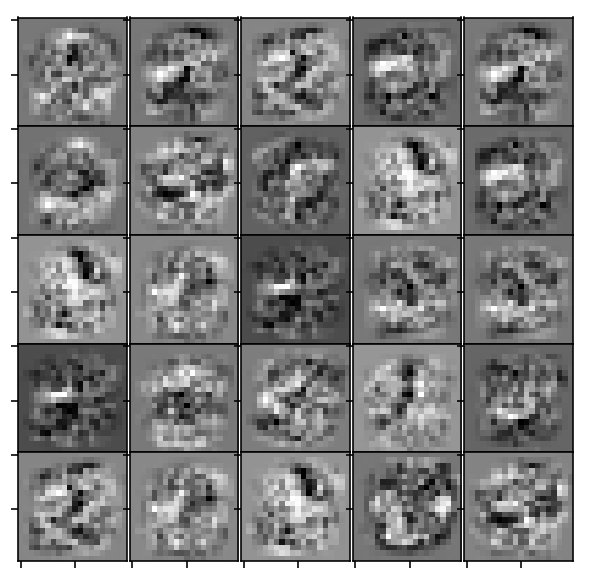

In [65]:
displayData(Theta1[:,1:], nrows = 5, ncols = 5)